   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

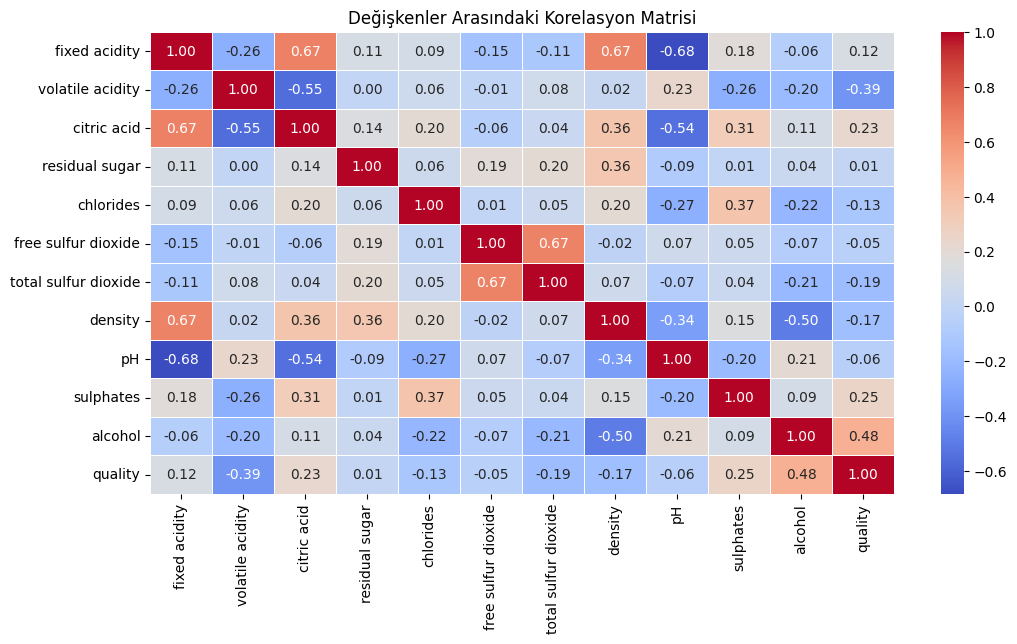

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veri setini yükleme
url = "winequality-red.csv"
veri = pd.read_csv(url)

# Veri setinin ilk 5 satırını gösterme
print(veri.head())

# Veri setinin genel bilgileri
print(veri.info())

# Veri setinin istatistiksel özetini alalım
print(veri.describe())

# Korelasyon matrisini görselleştirelim
corr = veri.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Değişkenler Arasındaki Korelasyon Matrisi")
plt.show()


In [5]:
veri.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Eksik verileri kontrol etme
print(veri.isnull().sum())

# 2. Normalleştirme (Standardizasyon)
scaler = StandardScaler()
veri[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] = scaler.fit_transform(veri[['fixed acidity', 'volatile acidity', 
                                                                                                                           'citric acid', 'residual sugar', 'chlorides', 
                                                                                                                           'free sulfur dioxide', 'total sulfur dioxide', 
                                                                                                                           'density', 'pH', 'sulphates', 'alcohol']])

# 4. Veri kümesini eğitim ve test kümelerine bölmek
X = veri.drop('quality', axis=1)
y = veri['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Eğitim ve test kümesinin boyutlarını kontrol edelim
print("Eğitim kümesi boyutu:", X_train.shape, y_train.shape)
print("Test kümesi boyutu:", X_test.shape, y_test.shape)


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Eğitim kümesi boyutu: (1199, 11) (1199,)
Test kümesi boyutu: (400, 11) (400,)


In [10]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Modelleri tanımlama
svm_model = SVC()
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
knn_model = KNeighborsClassifier()

# Çapraz doğrulama ile model performanslarını değerlendirme
models = [svm_model, dt_model, rf_model, gb_model, knn_model]
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{model.__class__.__name__} Doğruluk Oranları: {scores.mean()}")

# En iyi performansı gösteren modeli seçme
en_iyi_model = max(models, key=lambda model: cross_val_score(model, X_train, y_train, cv=5).mean())
print("En iyi model:", en_iyi_model.__class__.__name__)

# En iyi modeli eğitme
en_iyi_model.fit(X_train, y_train)


SVC Doğruluk Oranları: 0.6105822873082288
DecisionTreeClassifier Doğruluk Oranları: 0.5946861924686192
RandomForestClassifier Doğruluk Oranları: 0.6847942817294281
GradientBoostingClassifier Doğruluk Oranları: 0.6347384937238493
KNeighborsClassifier Doğruluk Oranları: 0.5654986052998605
En iyi model: RandomForestClassifier


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# RandomForestClassifier için olası hiperparametre değerlerinin bir listesini tanımlama
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Randomized Search CV uygulama
random_search = RandomizedSearchCV(en_iyi_model, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# En iyi parametreleri ve en iyi skoru yazdırma
print("En iyi parametreler:", random_search.best_params_)
print("En iyi skor:", random_search.best_score_)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Optimized model üzerinde tahmin yapma
y_pred = random_search.predict(X_test)

# Karışıklık matrisini oluşturma
cm = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:")
print(cm)

# Doğruluk (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk:", accuracy)

# Kesinlik (Precision)
precision = precision_score(y_test, y_pred, average='weighted')
print("Kesinlik:", precision)

# Duyarlılık (Recall)
recall = recall_score(y_test, y_pred, average='weighted')
print("Duyarlılık:", recall)

# F1-Skor
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-Skor:", f1)
